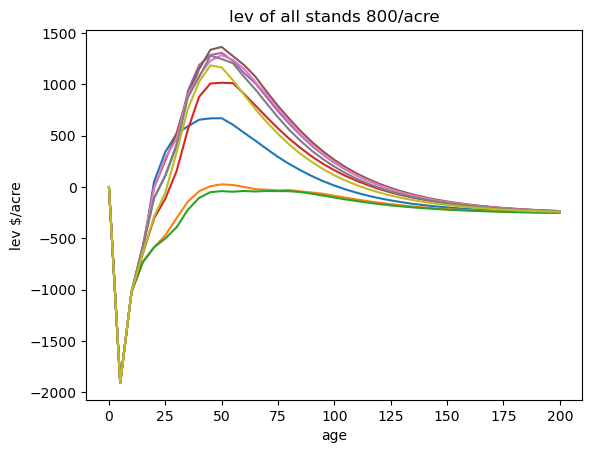

In [50]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def faustmann(profit, age):
    interest = 1.03
    cost = 262
    if age:
        revenue = (profit - (cost * interest ** age)) / ((interest ** age) - 1)
        return revenue
    else:
        return 0

interest = 1.03
cost = 262
ll_timber = 0.72
ll_pulp = 0.27
hw_timber = 23.25/35.31467
hw_pulp = 9.78/35.31467
    
ll_800 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/800LL.csv", delimiter = ";")
sg_800 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/800SG.csv", delimiter = ";")
wo_800 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/800WO.csv", delimiter = ";")
ll200_sg600 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/200LL_600SG.csv", delimiter = ";")
ll400_sg400 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/400LL_400SG.csv", delimiter = ";")
ll600_sg200 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/600LL_200SG.csv", delimiter = ";")
ll600_wo200 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/600LL_200WO.csv", delimiter = ";")
ll400_wo400 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/400LL_400WO.csv", delimiter = ";")
ll200_wo600 = pd.read_csv("/mnt/5A5136DD7377F658/rawdata/200LL_600WO.csv", delimiter = ";")

stands = [ll_800, sg_800, wo_800, ll200_sg600, ll400_sg400, ll600_sg200, ll600_wo200, ll400_wo400, ll200_wo600] 
stands_sg = [ll_800, ll600_sg200, ll400_sg400, ll200_sg600, sg_800]
stands_wo = [ll_800, ll600_wo200, ll400_wo400, ll200_wo600,  wo_800]


def lev(graphtitle, *args):  
    for stand in args:
        stand_list = list(stand)
        stand.insert(loc=1, column="age", value=[i for i in range(0, 205, 5)])
        if len(stand_list) > 6:
            stand["ll_pulp"] = stand.iloc[:,3] - stand.iloc[:,6]
            stand["hw_pulp"] = stand.iloc[:,4] - stand.iloc[:,7]
            stand["revenue"] = stand.iloc[:,6] * ll_timber + stand.iloc[:,6] * hw_timber + stand.iloc[:,8] * ll_pulp + stand.iloc[:,9] * hw_pulp
            stand["faustmann"] = stand[["revenue", "age"]].apply(lambda x: faustmann(x["revenue"], x["age"]), axis=1)
        else:
            stand["pulp"] = stand.iloc[:,3] - stand.iloc[:,5]
            if stand.iloc[3,2] == 0:
                stand["revenue"] = stand.iloc[:,5] * hw_timber + stand.iloc[:,6] * hw_pulp
            else:
                stand["revenue"] = stand.iloc[:,5] * ll_timber + stand.iloc[:,6] * ll_pulp
            stand["faustmann"] = stand[["revenue", "age"]].apply(lambda x: faustmann(x["revenue"], x["age"]), axis=1)
        plt.plot(stand["age"], stand["faustmann"])
        plt.xlabel("age")
        plt.ylabel("lev $/acre")
        plt.title(graphtitle)
    #ax.plot(data = stand, x = "age", y = "faustmann", legend = "full")
    #fig, ax = sns.lineplot(data = stand, x = "age", y = "faustmann", legend = "full")
    #ax.ylabel('revenue in $/acre')
    #plt.title("revenue of stands by faustmann")
    #ax.legend()
    

 
#sns.lineplot(data = wo_df["true volume"], marker = "o")
#ax2 = plt.twinx()
#sns.lineplot(data = wo_df["arithmetic"], marker = "o", ax= ax2)

#print(wo_arithmetic)
#wo_df.head()

lev("lev of all stands 800/acre", *stands)

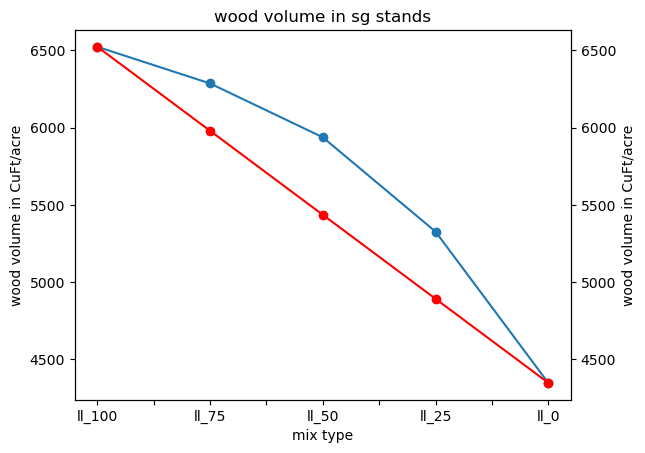

In [47]:

def volume(graphtitle, *args):
    volume_true = []
    volume_arithmetic = []
    for stand in args:
        volume_true.append(stand.loc[stand["age"] == 50]["Total_MCuFt"].item())
        
    volume_arithmetic.append(volume_true[0])
    volume_arithmetic.append(volume_true[0] * 0.75 + volume_true[-1] * 0.25)
    volume_arithmetic.append(volume_true[0] * 0.5 + volume_true[-1] * 0.5)   
    volume_arithmetic.append(volume_true[0] * 0.25 + volume_true[-1] * 0.75)
    volume_arithmetic.append(volume_true[-1])
    
    stand_df = pd.DataFrame()
    stand_df["mix type"] = ["ll_100", "ll_75", "ll_50", "ll_25", "ll_0"]
    stand_df["true volume"] = volume_true
    stand_df["arithmetic"] = volume_arithmetic
    vol_comp = stand_df.plot(x="mix type", y="true volume", legend=False, marker = "o")
    plt.ylabel("wood volume in CuFt/acre")
    vol_comp2 = vol_comp.twinx()
    stand_df.plot(x="mix type", y="arithmetic", ax=vol_comp2, legend=False, marker = "o", color="r")
    plt.title(graphtitle)
    plt.ylabel("wood volume in CuFt/acre")
    
    
volume("wood volume in sg stands", *stands_sg)      
  

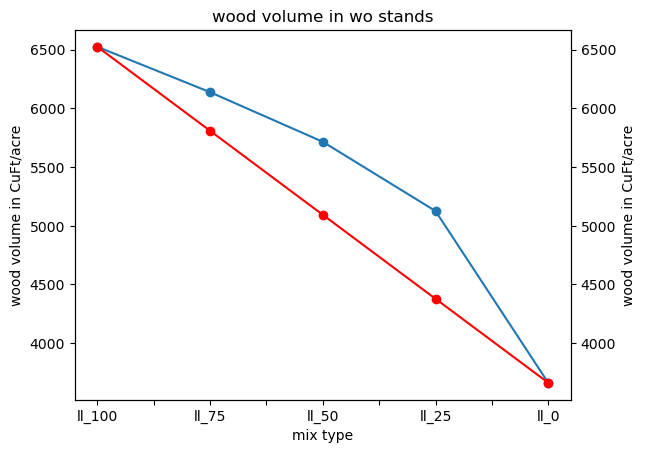

In [48]:
volume("wood volume in wo stands",*stands_wo)